In [648]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings('ignore')

In [649]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

In [1149]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from skimage import io, transform

# display images
from torchvision import utils
import torchvision

In [1150]:
path2csv = './database/metadata.csv'
df = pd.read_csv(path2csv)
dir_list = []
for i in range(len(df)):
    dir_list.append('./'+df['directory'][i])
df.drop(['name','index', 'directory'], axis=1, inplace=True)
#df.drop(['a','v'], axis=1, inplace=True)
df.tail(3)

,heat,weight,colorfulness,saturation,brightness,pleasure,dominance,horizontal_intensity,vertical_intensity,dynamic_intensity,...,waveletAV,waveletAD,waveletBH,waveletBV,waveletBD,vertical_similarity,horizontal_similarity,ruleOfThirds,a,v
54,0.502064,1.075300,28.727802,0.465279,0.530236,0.468224,-0.254090,0.695328,0.099177,0.196618,...,-0.000355,0.000574,-0.435728,-0.000355,-0.000574,0.980298,0.962079,0.964504,6.287000,6.471000
55,-0.797139,-0.927580,32.892406,0.508540,0.548231,0.490158,-0.253923,0.000000,0.557676,0.142048,...,-0.000109,0.001425,0.001237,0.001902,-0.001425,0.955615,0.962532,0.956674,3.582333,5.574667
56,1.237772,0.727806,18.670452,0.353079,0.585810,0.481887,-0.332231,2.961220,0.489046,0.261643,...,0.000000,0.000000,-0.233711,0.000000,0.000000,0.970833,0.958790,0.963362,5.919833,7.268000


In [1151]:
from sklearn.preprocessing import MinMaxScaler

feature = df.iloc[:, :-2]
scaler = MinMaxScaler()
scaler.fit(feature)
scaled = scaler.transform(feature)
X = pd.DataFrame(scaled, columns=df.columns.tolist()[:-2])
y = df.iloc[:,-2:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

In [1152]:
path2csv = './database/metadata.csv'
new_df = pd.read_csv(path2csv)
dir_list = []
for i in range(len(new_df)):
    dir_list.append('./'+new_df['directory'][i])
new_df.drop(['name','index'], axis=1, inplace=True)
#df.drop(['a','v'], axis=1, inplace=True)
new_df.tail(3)

,directory,heat,weight,colorfulness,saturation,brightness,pleasure,dominance,horizontal_intensity,vertical_intensity,...,waveletAV,waveletAD,waveletBH,waveletBV,waveletBD,vertical_similarity,horizontal_similarity,ruleOfThirds,a,v
54,database/painting/055.jpg,0.502064,1.075300,28.727802,0.465279,0.530236,0.468224,-0.254090,0.695328,0.099177,...,-0.000355,0.000574,-0.435728,-0.000355,-0.000574,0.980298,0.962079,0.964504,6.287000,6.471000
55,database/painting/056.jpg,-0.797139,-0.927580,32.892406,0.508540,0.548231,0.490158,-0.253923,0.000000,0.557676,...,-0.000109,0.001425,0.001237,0.001902,-0.001425,0.955615,0.962532,0.956674,3.582333,5.574667
56,database/painting/057.jpg,1.237772,0.727806,18.670452,0.353079,0.585810,0.481887,-0.332231,2.961220,0.489046,...,0.000000,0.000000,-0.233711,0.000000,0.000000,0.970833,0.958790,0.963362,5.919833,7.268000


## Random Forest

In [1153]:
rg = RandomForestRegressor(n_estimators=100,
                           criterion="mse",
                           n_jobs=-1,
                           random_state=0)

model = MultiOutputRegressor(estimator=rg)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print('Train A MSE:', mean_squared_error(y_train.iloc[:,0], y_pred_train[:,0]))
print('Train V MSE:',mean_squared_error(y_train.iloc[:,1], y_pred_train[:,1]))
print('Test A MSE:', mean_squared_error(y_test.iloc[:,0], y_pred_test[:,0]))
print('Test V MSE:',mean_squared_error(y_test.iloc[:,1], y_pred_test[:,1]))

Train A MSE: 0.41156294359135803
Train V MSE: 0.44241858929260314
Test A MSE: 2.175896981350324
Test V MSE: 1.2891795757148994


In [1154]:
model.get_params().keys()

dict_keys(['estimator__bootstrap', 'estimator__criterion', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__min_impurity_decrease', 'estimator__min_impurity_split', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__oob_score', 'estimator__random_state', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs'])

In [1155]:
param_grid = {
    "n_estimators":[50,100,200,300,500],
    "max_depth":[5, 8, 10, 50, 100, 200],
    "max_features":[6, 8, 10, 12, 14, 16]
}

rf_reg = RandomForestRegressor()

rf_reg_tuned = GridSearchCV(estimator=rf_reg,
                            param_grid=param_grid,
                            cv=3,
                            n_jobs=-1,
                            verbose=2)

rf_reg_tuned.fit(X_train, y_train)

rf_reg_tuned.best_estimator_



Fitting 3 folds for each of 180 candidates, totalling 540 fits
[CV] max_depth=5, max_features=6, n_estimators=50 ....................
[CV] max_depth=5, max_features=6, n_estimators=50 ....................
[CV] max_depth=5, max_features=6, n_estimators=50 ....................
[CV] max_depth=5, max_features=6, n_estimators=100 ...................
[CV] max_depth=5, max_features=6, n_estimators=100 ...................
[CV] max_depth=5, max_features=6, n_estimators=100 ...................
[CV] max_depth=5, max_features=6, n_estimators=200 ...................
[CV] max_depth=5, max_features=6, n_estimators=200 ...................
[CV] max_depth=5, max_features=6, n_estimators=200 ...................
[CV] max_depth=5, max_features=6, n_estimators=300 ...................
[CV] max_depth=5, max_features=6, n_estimators=300 ...................
[CV] max_depth=5, max_features=6, n_estimators=300 ...................
[CV] max_depth=5, max_features=6, n_estimators=500 ...................
[CV] max_depth

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s


[CV] .... max_depth=5, max_features=10, n_estimators=50, total=   0.1s
[CV] .... max_depth=5, max_features=10, n_estimators=50, total=   0.1s
[CV] max_depth=5, max_features=10, n_estimators=100 ..................
[CV] max_depth=5, max_features=10, n_estimators=500 ..................
[CV] .... max_depth=5, max_features=8, n_estimators=200, total=   0.4s
[CV] max_depth=5, max_features=10, n_estimators=500 ..................
[CV] ... max_depth=5, max_features=10, n_estimators=100, total=   0.1s
[CV] max_depth=5, max_features=10, n_estimators=100 ..................
[CV] .... max_depth=5, max_features=8, n_estimators=300, total=   0.4s
[CV] .... max_depth=5, max_features=6, n_estimators=500, total=   0.7s
[CV] max_depth=5, max_features=12, n_estimators=50 ...................
[CV] .... max_depth=5, max_features=8, n_estimators=300, total=   0.4s
[CV] ... max_depth=5, max_features=10, n_estimators=100, total=   0.1s
[CV] .... max_depth=5, max_features=8, n_estimators=300, total=   0.4s
[CV] m

[CV] max_depth=5, max_features=16, n_estimators=500 ..................
[CV] max_depth=5, max_features=16, n_estimators=300 ..................
[CV] ... max_depth=5, max_features=14, n_estimators=300, total=   0.4s
[CV] max_depth=8, max_features=6, n_estimators=500 ...................
[CV] ... max_depth=5, max_features=14, n_estimators=500, total=   0.7s
[CV] max_depth=5, max_features=14, n_estimators=500 ..................
[CV] ... max_depth=5, max_features=14, n_estimators=500, total=   0.7s
[CV] max_depth=5, max_features=16, n_estimators=50 ...................
[CV] .... max_depth=8, max_features=6, n_estimators=100, total=   0.2s
[CV] .... max_depth=8, max_features=6, n_estimators=100, total=   0.1s
[CV] max_depth=8, max_features=8, n_estimators=50 ....................
[CV] max_depth=8, max_features=6, n_estimators=500 ...................
[CV] ... max_depth=5, max_features=12, n_estimators=500, total=   0.7s
[CV] max_depth=8, max_features=8, n_estimators=100 ...................
[CV] .

[CV] ... max_depth=8, max_features=12, n_estimators=300, total=   0.4s
[CV] max_depth=8, max_features=12, n_estimators=300 ..................
[CV] ... max_depth=8, max_features=12, n_estimators=200, total=   0.3s
[CV] max_depth=8, max_features=14, n_estimators=300 ..................
[CV] ... max_depth=8, max_features=10, n_estimators=300, total=   0.4s
[CV] max_depth=8, max_features=14, n_estimators=500 ..................
[CV] ... max_depth=8, max_features=14, n_estimators=100, total=   0.1s
[CV] ... max_depth=8, max_features=10, n_estimators=500, total=   0.7s
[CV] max_depth=8, max_features=10, n_estimators=500 ..................
[CV] max_depth=8, max_features=14, n_estimators=500 ..................
[CV] ... max_depth=8, max_features=12, n_estimators=300, total=   0.4s
[CV] max_depth=8, max_features=12, n_estimators=500 ..................
[CV] .... max_depth=8, max_features=8, n_estimators=500, total=   0.7s
[CV] max_depth=8, max_features=16, n_estimators=50 ...................
[CV] .

[CV] ... max_depth=10, max_features=8, n_estimators=200, total=   0.3s
[CV] max_depth=10, max_features=10, n_estimators=200 .................
[CV] ... max_depth=10, max_features=10, n_estimators=50, total=   0.1s
[CV] max_depth=10, max_features=10, n_estimators=300 .................
[CV] .. max_depth=10, max_features=10, n_estimators=100, total=   0.2s
[CV] max_depth=10, max_features=10, n_estimators=100 .................
[CV] .. max_depth=10, max_features=10, n_estimators=100, total=   0.1s
[CV] max_depth=10, max_features=10, n_estimators=500 .................
[CV] ... max_depth=10, max_features=6, n_estimators=300, total=   0.4s
[CV] max_depth=10, max_features=10, n_estimators=500 .................
[CV] ... max_depth=10, max_features=8, n_estimators=300, total=   0.4s
[CV] max_depth=10, max_features=8, n_estimators=500 ..................
[CV] ... max_depth=10, max_features=8, n_estimators=300, total=   0.5s
[CV] max_depth=10, max_features=8, n_estimators=300 ..................
[CV] .

[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    5.2s


[CV] .. max_depth=10, max_features=12, n_estimators=500, total=   0.7s
[CV] max_depth=10, max_features=12, n_estimators=500 .................
[CV] .. max_depth=10, max_features=14, n_estimators=300, total=   0.4s
[CV] max_depth=10, max_features=14, n_estimators=300 .................
[CV] ... max_depth=10, max_features=8, n_estimators=500, total=   0.7s
[CV] max_depth=50, max_features=6, n_estimators=50 ...................
[CV] .. max_depth=10, max_features=16, n_estimators=100, total=   0.1s
[CV] max_depth=50, max_features=6, n_estimators=50 ...................
[CV] .. max_depth=10, max_features=14, n_estimators=200, total=   0.3s
[CV] .. max_depth=10, max_features=16, n_estimators=200, total=   0.3s
[CV] max_depth=10, max_features=16, n_estimators=200 .................
[CV] max_depth=50, max_features=6, n_estimators=100 ..................
[CV] .. max_depth=10, max_features=12, n_estimators=300, total=   0.5s
[CV] max_depth=50, max_features=6, n_estimators=200 ..................
[CV] .

[CV] .. max_depth=50, max_features=12, n_estimators=100, total=   0.1s
[CV] max_depth=50, max_features=12, n_estimators=100 .................
[CV] .. max_depth=50, max_features=12, n_estimators=100, total=   0.1s
[CV] max_depth=50, max_features=12, n_estimators=200 .................
[CV] .. max_depth=50, max_features=10, n_estimators=300, total=   0.4s
[CV] max_depth=50, max_features=10, n_estimators=300 .................
[CV] .. max_depth=50, max_features=12, n_estimators=100, total=   0.1s
[CV] max_depth=50, max_features=14, n_estimators=50 ..................
[CV] .. max_depth=10, max_features=16, n_estimators=500, total=   0.7s
[CV] .. max_depth=50, max_features=12, n_estimators=200, total=   0.3s
[CV] max_depth=50, max_features=12, n_estimators=200 .................
[CV] max_depth=50, max_features=14, n_estimators=50 ..................
[CV] ... max_depth=50, max_features=8, n_estimators=500, total=   0.8s
[CV] max_depth=50, max_features=8, n_estimators=500 ..................
[CV] .

[CV] .. max_depth=100, max_features=6, n_estimators=200, total=   0.3s
[CV] max_depth=100, max_features=6, n_estimators=300 .................
[CV] ... max_depth=100, max_features=8, n_estimators=50, total=   0.1s
[CV] max_depth=100, max_features=8, n_estimators=500 .................
[CV] .. max_depth=100, max_features=8, n_estimators=100, total=   0.1s
[CV] max_depth=100, max_features=8, n_estimators=100 .................
[CV] .. max_depth=100, max_features=8, n_estimators=100, total=   0.1s
[CV] max_depth=100, max_features=8, n_estimators=200 .................
[CV] .. max_depth=50, max_features=16, n_estimators=500, total=   0.7s
[CV] max_depth=50, max_features=16, n_estimators=500 .................
[CV] .. max_depth=100, max_features=6, n_estimators=300, total=   0.4s
[CV] max_depth=100, max_features=6, n_estimators=300 .................
[CV] .. max_depth=100, max_features=8, n_estimators=100, total=   0.1s
[CV] max_depth=100, max_features=10, n_estimators=50 .................
[CV] .

[CV] .. max_depth=100, max_features=12, n_estimators=50, total=   0.1s
[CV] max_depth=100, max_features=16, n_estimators=300 ................
[CV] . max_depth=100, max_features=14, n_estimators=200, total=   0.3s
[CV] max_depth=100, max_features=14, n_estimators=300 ................
[CV] . max_depth=100, max_features=10, n_estimators=300, total=   0.4s
[CV] max_depth=100, max_features=16, n_estimators=300 ................
[CV] .. max_depth=100, max_features=16, n_estimators=50, total=   0.1s
[CV] . max_depth=100, max_features=16, n_estimators=100, total=   0.1s
[CV] max_depth=100, max_features=16, n_estimators=100 ................
[CV] max_depth=100, max_features=16, n_estimators=500 ................
[CV] . max_depth=100, max_features=16, n_estimators=100, total=   0.1s
[CV] . max_depth=100, max_features=12, n_estimators=500, total=   0.7s
[CV] max_depth=100, max_features=16, n_estimators=200 ................
[CV] max_depth=100, max_features=12, n_estimators=500 ................
[CV] .

[CV] .. max_depth=200, max_features=6, n_estimators=300, total=   0.4s
[CV] max_depth=200, max_features=12, n_estimators=100 ................
[CV] ... max_depth=200, max_features=8, n_estimators=50, total=   0.1s
[CV] .. max_depth=200, max_features=8, n_estimators=200, total=   0.3s
[CV] max_depth=200, max_features=12, n_estimators=200 ................
[CV] max_depth=200, max_features=12, n_estimators=300 ................
[CV] . max_depth=200, max_features=10, n_estimators=200, total=   0.3s
[CV] max_depth=200, max_features=10, n_estimators=300 ................
[CV] .. max_depth=200, max_features=12, n_estimators=50, total=   0.1s
[CV] max_depth=200, max_features=12, n_estimators=300 ................
[CV] . max_depth=100, max_features=14, n_estimators=500, total=   0.7s
[CV] max_depth=200, max_features=12, n_estimators=500 ................
[CV] . max_depth=200, max_features=12, n_estimators=100, total=   0.1s
[CV] max_depth=200, max_features=12, n_estimators=100 ................
[CV] .

[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   12.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [1156]:
import time
    
start = time.time()  # 시작 시간 저장
y_pred_test = rf_reg_tuned.predict(X_test)

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 0.002832174301147461


In [1170]:
model = rf_reg_tuned.best_estimator_

model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

print('Train A MSE:', mean_squared_error(y_train.iloc[:,0], y_pred_train[:,0]))
print('Train V MSE:',mean_squared_error(y_train.iloc[:,1], y_pred_train[:,1]))
print('Test A MSE:', mean_squared_error(y_test.iloc[:,0], y_pred_test[:,0]))
print('Test V MSE:',mean_squared_error(y_test.iloc[:,1], y_pred_test[:,1]))
print(mean_squared_error(y_test.iloc[:,0], y_pred_test[:,0])+mean_squared_error(y_test.iloc[:,1], y_pred_test[:,1]))

Train A MSE: 0.4399490843637993
Train V MSE: 0.36097288182339166
Test A MSE: 1.4134242279763973
Test V MSE: 1.090202272601511
2.5036265005779086


In [1177]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print("{}. feature {} ({:.3f})".format(f + 1, X.columns[indices][f], importances[indices[f]]))

Feature ranking:
1. feature horizontal_intensity (0.123)
2. feature pleasure (0.109)
3. feature dominance (0.082)
4. feature brightness (0.078)
5. feature colorfulness (0.061)
6. feature saturation (0.045)
7. feature waveletLV (0.045)
8. feature waveletBD (0.041)
9. feature vertical_intensity (0.040)
10. feature dynamic_intensity (0.038)
11. feature vertical_similarity (0.037)
12. feature waveletBV (0.033)
13. feature horizontal_similarity (0.033)
14. feature waveletAD (0.032)
15. feature ruleOfThirds (0.032)
16. feature waveletLD (0.031)
17. feature waveletAV (0.027)
18. feature waveletLH (0.027)
19. feature waveletBH (0.026)
20. feature waveletAH (0.022)
21. feature weight (0.021)
22. feature heat (0.015)


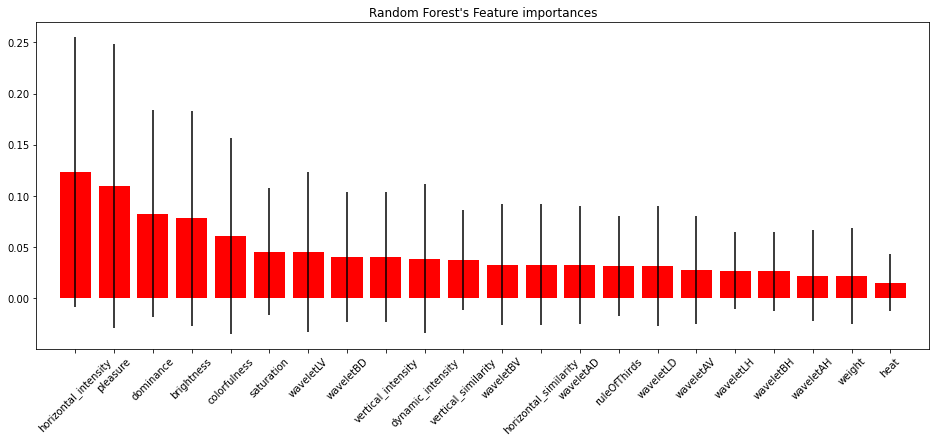

In [1178]:
plt.figure(figsize=(16,6))
plt.title("Random Forest's Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

## GBR

In [1087]:
GBR = GradientBoostingRegressor(n_estimators=50,
                                learning_rate =0.1,
                                max_depth=1,
                                max_features=3,
                           criterion="mse")
model = MultiOutputRegressor(estimator=GBR)

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

print('Train A MSE:', mean_squared_error(y_train.iloc[:,0], y_pred_train[:,0]))
print('Train V MSE:',mean_squared_error(y_train.iloc[:,1], y_pred_train[:,1]))
print('Test A MSE:', mean_squared_error(y_test.iloc[:,0], y_pred_test[:,0]))
print('Test V MSE:',mean_squared_error(y_test.iloc[:,1], y_pred_test[:,1]))
print(mean_squared_error(y_test.iloc[:,0], y_pred_test[:,0])+mean_squared_error(y_test.iloc[:,1], y_pred_test[:,1]))

Train A MSE: 0.9231332542251869
Train V MSE: 1.055815812271985
Test A MSE: 1.7052517389686983
Test V MSE: 1.5107674913057938
3.216019230274492


In [855]:
model.get_params().keys()

dict_keys(['estimator__alpha', 'estimator__criterion', 'estimator__init', 'estimator__learning_rate', 'estimator__loss', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__min_impurity_decrease', 'estimator__min_impurity_split', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__n_estimators', 'estimator__presort', 'estimator__random_state', 'estimator__subsample', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs'])

In [1088]:
import sys
import pickle
p = pickle.dumps(model)
print(sys.getsizeof(p))

59352


## DNN

In [1126]:
import random
def make_reproducible(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
make_reproducible()

In [1127]:
class paintingDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        
        self.metadata = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = './' + self.metadata.iloc[idx, 0]
        image = Image.open(img_name)
        feature = self.metadata.iloc[idx,-2:]
        feature = np.array([feature])
        feature = feature.astype('float').reshape(-1)
        
        #sample = {'image': image, 'feature': feature}
        
        if self.transform is not None:
            image = self.transform(image)

        return image, feature

In [1128]:
def testing(model, mode='Test'):
    with torch.no_grad():
        a_temp = 0.0
        v_temp = 0.0
        if mode == 'Train':
            for data in train_loader:
                model = model.to(device)
                model = model.eval()

                features, av = data[0].to(device), data[1].to(device)
                y_pred = model(features.float())

                a_temp += mean_squared_error(y_pred[:,0].cpu(), av[:,0].cpu())
                v_temp += mean_squared_error(y_pred[:,1].cpu(), av[:,1].cpu())
            
            A_MSE = a_temp / len(train_loader)
            V_MSE = v_temp / len(train_loader)
            
        else :
            for data in test_loader:
                model = model.to(device)
                model = model.eval()

                features, av = data[0].to(device), data[1].to(device)
                y_pred = model(features.float())

                a_temp += mean_squared_error(y_pred[:,0].cpu(), av[:,0].cpu())
                v_temp += mean_squared_error(y_pred[:,1].cpu(), av[:,1].cpu())

            A_MSE = a_temp / len(test_loader)
            V_MSE = v_temp / len(test_loader)

        #print('Test A MSE:', A_MSE)
        #print('Test V MSE:', V_MSE)
    return A_MSE, V_MSE

In [1129]:
batch_size = 1
num_epochs = 100
learning_late = 0.0001

In [1130]:
import torch.utils.data as data_utils

train = data_utils.TensorDataset(torch.Tensor(np.array(X_train)), torch.Tensor(np.array(y_train)))
train_loader = data_utils.DataLoader(train, batch_size = batch_size, shuffle = True)
test = data_utils.TensorDataset(torch.Tensor(np.array(X_test)), torch.Tensor(np.array(y_test)))
test_loader = data_utils.DataLoader(test, batch_size = batch_size, shuffle = False)

In [1131]:
torch.Tensor(np.array(X_train)).size()
#torch.Tensor(np.array(y_train)).size()

torch.Size([39, 22])

In [1132]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 8)
        self.layer_2 = nn.Linear(8, 16)
        self.layer_3 = nn.Linear(16, 64)
        self.layer_out = nn.Linear(64, 2)
        
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)
    
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)

In [1133]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dnn = MultipleRegression(22)
dnn = dnn.to(device)

criterion = nn.MSELoss()
opt = optim.SGD(dnn.parameters(), lr=learning_late)

scheduler = optim.lr_scheduler.LambdaLR(optimizer=opt,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1)


In [1138]:
import torch.optim as optim

batch_size = 1
num_epochs = 200
learning_late = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dnn = MultipleRegression(22)
dnn = dnn.to(device)

criterion = nn.MSELoss()
opt = optim.SGD(dnn.parameters(), lr=learning_late)

scheduler = optim.lr_scheduler.LambdaLR(optimizer=opt,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1)


train_loss_list = []
test_loss_list = []
a_mse_list = []
v_mse_list = []

In [1140]:

for epoch in range(num_epochs):
    train_loss = 0.0
    
    dnn.train()
    for data in train_loader:
        features, av = data[0].to(device), data[1].to(device)
        
        opt.zero_grad()
        #print(features.size())
        y_pred = dnn(features.float())
        #av = (av_r + av_d)/2
        
        loss = loss_func(y_pred, av.float())
        
        loss.backward()
        
        opt.step()

        train_loss += loss.item()
        
    train_loss = train_loss / len(train_loader)
    train_loss_list.append(train_loss)
    
    dnn.eval()
    with torch.no_grad():
        test_loss = 0.0
        for data in test_loader:
            features, av = data[0].to(device), data[1].to(device)
            y_pred = dnn(features.float())
            
            loss = loss_func(y_pred, av.float())
            
            test_loss += loss.item()

        test_loss = test_loss / len(test_loader)
        test_loss_list.append(test_loss)
    
    if epoch % 20 == 0:
        print('[epoch %d] Train loss: %.3f, Test loss: %.3f' %(epoch, train_loss, test_loss))
        print(testing(dnn))
    a_mse, v_mse = testing(dnn)
    a_mse_list.append(a_mse)
    v_mse_list.append(v_mse)

[epoch 0] Train loss: 2.114, Test loss: 2.835
(3.059409452084866, 2.6105885413578815)
[epoch 20] Train loss: 2.098, Test loss: 2.854
(2.9446555618196726, 2.7629225570708513)
[epoch 40] Train loss: 2.043, Test loss: 2.946
(2.970761425793171, 2.9207326577355466)
[epoch 60] Train loss: 1.998, Test loss: 3.017
(3.0167948057254157, 3.0164916962385178)
[epoch 80] Train loss: 1.956, Test loss: 3.182
(3.1864078518831067, 3.1785765066742897)
[epoch 100] Train loss: 1.900, Test loss: 3.315
(3.2076694241000547, 3.421944516400496)
[epoch 120] Train loss: 1.791, Test loss: 3.395
(3.224880682511462, 3.5656554102897644)
[epoch 140] Train loss: 1.765, Test loss: 3.712
(3.3908595045407615, 4.03219151434799)
[epoch 160] Train loss: 1.568, Test loss: 3.959
(3.6059357362488904, 4.311369778045143)
[epoch 180] Train loss: 1.496, Test loss: 4.219
(3.6926689512199826, 4.745278427241526)


In [1142]:
import time

with torch.no_grad():
    dnn = dnn.to(device)
    dnn = dnn.eval()
    
    start = time.time()  # 시작 시간 저장
    for data in test_loader:
        features, av = data[0].to(device), data[1].to(device)
        y_pred = dnn(features.float())

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 0.006132841110229492


In [1108]:
import sys
import pickle
p = pickle.dumps(dnn)
print(sys.getsizeof(p))

9882


In [1113]:
torchsummary.summary(dnn, (1, 22), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [1, 1, 8]             184
              ReLU-2                  [1, 1, 8]               0
            Linear-3                 [1, 1, 16]             144
              ReLU-4                 [1, 1, 16]               0
            Linear-5                 [1, 1, 64]           1,088
              ReLU-6                 [1, 1, 64]               0
            Linear-7                  [1, 1, 2]             130
Total params: 1,546
Trainable params: 1,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


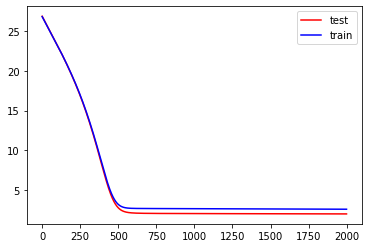

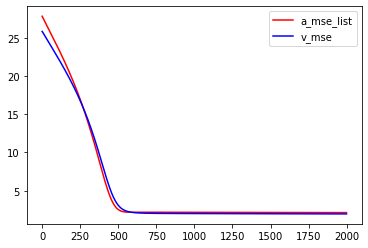

(2.129019441515185, 1.9571328748295653)
(2.3313015073109478, 2.9292214445960827)


In [977]:
plt.plot(test_loss_list, c='r', label='test')
plt.plot(train_loss_list, c='b', label='train')
plt.legend()
plt.show()
plt.plot(a_mse_list, c='r', label='a_mse_list')
plt.plot(v_mse_list, c='b', label='v_mse')
plt.legend()
plt.show()
print(testing(dnn, 'Test'))
print(testing(dnn, 'Train'))

## ResNet

In [1114]:
def testing(model):
    with torch.no_grad():
        a_temp = 0.0
        v_temp = 0.0
        for data in test_loader:
            model = model.to(device)
            model = model.eval()

            inputs, gt = data[0].to(device), data[1].to(device)
            output = model(inputs)

            a_temp += mean_squared_error(output[:,0].cpu(), gt[:,0].cpu())
            v_temp += mean_squared_error(output[:,1].cpu(), gt[:,1].cpu())
        A_MSE = a_temp / len(train_loader)
        V_MSE = v_temp / len(train_loader)
    return A_MSE, V_MSE

In [1115]:
new_y_train = y_train.copy()
new_y_test = y_test.copy()
new_y_train['index'] = new_y_train.index
new_y_test['index'] = new_y_test.index
new_y_train['directory']= new_y_train['index']
new_y_test['directory']= new_y_test['index']
for i in range(len(new_y_train)):
    new_y_train['directory'].iloc[i] = '%03d.jpg'%(int(new_y_train['index'].iloc[i])+1)
new_y_train.drop('index',  axis=1, inplace=True)
for i in range(len(new_y_test)):
    new_y_test['directory'].iloc[i] = '%03d.jpg'%(int(new_y_test['index'].iloc[i])+1)
new_y_test.drop('index',  axis=1, inplace=True)

In [1116]:
new_y_train.head()

,a,v,directory
14,4.004000,3.329833,015.jpg
31,5.482667,2.095833,032.jpg
28,1.736000,1.828000,029.jpg
46,6.777833,5.505333,047.jpg
51,3.582333,4.992667,052.jpg


In [1117]:
new_y_test.head()

,a,v,directory
35,2.885333,3.467667,036.jpg
34,5.904000,2.885000,035.jpg
41,6.716333,6.939000,042.jpg
27,7.260500,5.068667,028.jpg
11,6.180333,3.613333,012.jpg


In [1118]:
from torch.utils.data import Dataset
from PIL import Image

class paintingDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        
        self.metadata = dataframe
        self.root_dir = './database/painting/'
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.root_dir + str(self.metadata['directory'].iloc[idx])
        
        image = Image.open(img_name)
        
        feature = self.metadata[['a','v']].iloc[idx]
        
        feature = np.array([feature])
        
        feature = feature.astype('float').reshape(-1)
        
        
        if self.transform is not None:
            image = self.transform(image)

        return image, feature

In [1119]:
train_dataset = paintingDataset(new_y_train, transform=transforms.Compose([
                                               transforms.Resize(256),
                                               transforms.RandomCrop(224),
                                               transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                           ]))
test_dataset = paintingDataset(new_y_test, transform=transforms.Compose([
                                               transforms.Resize(256),
                                               transforms.RandomCrop(224),
                                               transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                           ]))

In [1120]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=16, 
                                             shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=16, 
                                             shuffle=False)

torch.Size([16, 3, 224, 224])


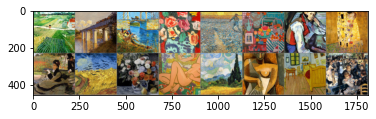

tensor([[7.3138, 6.7395],
        [4.5630, 3.7355],
        [5.9273, 2.6860],
        [3.5823, 4.9927],
        [4.1417, 7.0765],
        [5.3678, 6.3795],
        [6.7853, 4.8315],
        [4.1650, 4.1345],
        [5.7967, 2.0730],
        [6.7778, 5.5053],
        [5.6513, 5.0993],
        [7.7202, 7.3068],
        [3.4058, 2.6627],
        [4.0040, 3.3298],
        [1.7360, 1.8280],
        [4.2185, 3.6665]], dtype=torch.float64)


In [1121]:
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, features = dataiter.next()
print(images.size())
imshow(torchvision.utils.make_grid(images))
print(features)

In [1122]:
from model.resnet import *
import torchsummary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = resnet50().to(device)

num_epochs = 200
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=0.0001)

net = model
torchsummary.summary(net, (3, 224, 224), batch_size=4)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 112, 112]           9,408
       BatchNorm2d-2          [4, 64, 112, 112]             128
              ReLU-3          [4, 64, 112, 112]               0
         MaxPool2d-4            [4, 64, 56, 56]               0
            Conv2d-5            [4, 64, 56, 56]           4,096
       BatchNorm2d-6            [4, 64, 56, 56]             128
              ReLU-7            [4, 64, 56, 56]               0
            Conv2d-8            [4, 64, 56, 56]          36,864
       BatchNorm2d-9            [4, 64, 56, 56]             128
             ReLU-10            [4, 64, 56, 56]               0
           Conv2d-11           [4, 256, 56, 56]          16,384
      BatchNorm2d-12           [4, 256, 56, 56]             512
           Conv2d-13           [4, 256, 56, 56]          16,384
      BatchNorm2d-14           [4,

In [1123]:
import sys
import pickle
p = pickle.dumps(net)
print(sys.getsizeof(p))

94584609


In [1060]:
resnet50_train_loss_list = []
resnet50_test_loss_list = []
for epoch in range(num_epochs):
    train_loss = 0.0
    
    model.train()
    for data in train_loader:
        inputs, gt = data[0].to(device), data[1].to(device)
        
        opt.zero_grad()
        av = model(inputs)
        loss = loss_func(av, gt.float())
        loss.backward()
        
        opt.step()

        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    resnet50_train_loss_list.append(train_loss)
    
    model.eval() 
    with torch.no_grad():
        test_loss = 0.0
        for data in test_loader:
            inputs, gt = data[0].to(device), data[1].to(device)
            av = model(inputs)
            loss = loss_func(av, gt.float())
            test_loss += loss.item()
        test_loss = test_loss / len(test_loader)
        resnet50_test_loss_list.append(test_loss)


    print('[epoch %d] Train loss: %.3f, Test loss: %.3f' %(epoch, train_loss, test_loss))
    print(testing(model))#a_mse, v_mse = testing(model)[0], testing(model)[1]
    #print('test a_mse %.3f, v_mse %.3f' %(a_mse, v_mse))

[epoch 0] Train loss: 7.664, Test loss: 14.409
(8.354560085410826, 10.881269640908847)
[epoch 1] Train loss: 4.963, Test loss: 10.057


KeyboardInterrupt: 

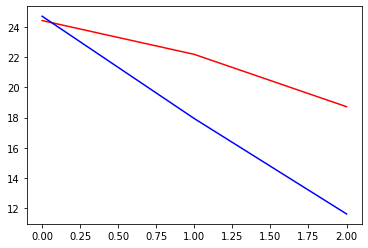

In [1059]:
plt.plot(resnet50_test_loss_list, c='r')
plt.plot(resnet50_train_loss_list, c='b')

In [1070]:
import time

with torch.no_grad():
    model = model.to(device)
    model = model.eval()
    
    start = time.time()  # 시작 시간 저장
    for data in test_loader:
        inputs, gt = data[0].to(device), data[1].to(device)
        output = model(inputs)
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 0.851205587387085


In [1124]:
from model.resnet import *
import torchsummary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = resnet34().to(device)

num_epochs = 200
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=0.00001)

net = model
torchsummary.summary(net, (3, 224, 224), batch_size=4)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 112, 112]           9,408
       BatchNorm2d-2          [4, 64, 112, 112]             128
              ReLU-3          [4, 64, 112, 112]               0
         MaxPool2d-4            [4, 64, 56, 56]               0
            Conv2d-5            [4, 64, 56, 56]          36,864
       BatchNorm2d-6            [4, 64, 56, 56]             128
              ReLU-7            [4, 64, 56, 56]               0
            Conv2d-8            [4, 64, 56, 56]          36,864
       BatchNorm2d-9            [4, 64, 56, 56]             128
             ReLU-10            [4, 64, 56, 56]               0
       BasicBlock-11            [4, 64, 56, 56]               0
           Conv2d-12            [4, 64, 56, 56]          36,864
      BatchNorm2d-13            [4, 64, 56, 56]             128
             ReLU-14            [4

In [1125]:
import sys
import pickle
p = pickle.dumps(net)
print(sys.getsizeof(p))

85356461


In [1072]:
resnet34_train_loss_list = []
resnet34_test_loss_list = []
for epoch in range(num_epochs):
    train_loss = 0.0
    
    model.train()
    for data in train_loader:
        inputs, gt = data[0].to(device), data[1].to(device)
        
        opt.zero_grad()
        av = model(inputs)
        loss = loss_func(av, gt.float())
        loss.backward()
        
        opt.step()

        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    resnet34_train_loss_list.append(train_loss)
    
    model.eval() 
    with torch.no_grad():
        test_loss = 0.0
        for data in test_loader:
            inputs, gt = data[0].to(device), data[1].to(device)
            av = model(inputs)
            loss = loss_func(av, gt.float())
            test_loss += loss.item()
        test_loss = test_loss / len(test_loader)
        resnet34_test_loss_list.append(test_loss)


    print('[epoch %d] Train loss: %.3f, Test loss: %.3f' %(epoch, train_loss, test_loss))
    print(testing(model))#a_mse, v_mse = testing(model)[0], testing(model)[1]
    #print('test a_mse %.3f, v_mse %.3f' %(a_mse, v_mse))

[epoch 0] Train loss: 26.573, Test loss: 24.822
(15.456558174357227, 17.566755765217533)


KeyboardInterrupt: 

In [ ]:
plt.plot(resnet34_test_loss_list, c='r')
plt.plot(resnet34_train_loss_list, c='b')

In [1083]:
import time
with torch.no_grad():
    model = model.to(device)
    model = model.eval()
    
    start = time.time()  # 시작 시간 저장
    for data in test_loader:
        inputs, gt = data[0].to(device), data[1].to(device)
        output = model(inputs)
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 0.8088247776031494
